In [77]:
CHECK_ID = "3fbcec6b-fba0-4ca6-bb2e-b7c64c2f1e9f"  # Can be overridden as needed
REGION = "us-east-1"

from datetime import datetime, timedelta

# Default to last 24 hours from now
def get_time_range(end_time=None, hours=24):
    if end_time is None:
        end_time = datetime.now()
    start_time = end_time - timedelta(hours=hours)
    return start_time, end_time

# Get the time range
start_time, end_time = get_time_range(end_time=datetime.now().replace(hour=10, minute=0, second=0, microsecond=0))

In [78]:
# connect to a postgres db read the DATABASE_URL from the environment variable
import psycopg2
import os

from dotenv import dotenv_values
config = dotenv_values("../.env")

conn = psycopg2.connect(
    config["DATABASE_URL"]
)

cursor = conn.cursor()

In [79]:
query = """
SELECT 
  "checkId",
  "runLocation",
  count(*)::integer as "count",
  count(*) filter (where "hasErrors" = false and "hasFailures" = false and "isDegraded" = false)::integer as "passingCount", 
  count(*) filter (where "hasErrors" = true or "hasFailures" = true)::integer as "errorCount",
  count(*) filter (where "isDegraded" = true)::integer as "degradedCount",
  date_bin('30 minutes', "startedAt", timestamp '2000-01-01') as "startedAtBin"
FROM check_results
WHERE 
  "checkId" = %s AND
  "runLocation" = %s AND
  "startedAt" BETWEEN %s AND %s
GROUP BY 
  "checkId",
  "runLocation", 
  date_bin('30 minutes', "startedAt", timestamp '2000-01-01')
ORDER BY "startedAtBin" ASC;
"""

# Execute the query with parameters
cursor.execute(query, (
    CHECK_ID,
    REGION,
    start_time.isoformat(),
    end_time.isoformat()
))

# Fetch all results
results = cursor.fetchall()
results



[('3fbcec6b-fba0-4ca6-bb2e-b7c64c2f1e9f',
  'us-east-1',
  1,
  1,
  0,
  0,
  datetime.datetime(2025, 3, 24, 8, 0, tzinfo=datetime.timezone.utc))]

In [80]:

from pytz import timezone
import pandas as pd
import pytz

# Convert results to pandas DataFrame
df = pd.DataFrame(results, columns=['checkId', 'runLocation', 'count', 'passingCount', 'errorCount', 'degradedCount', 'startedAtBin'])

# Calculate mean pass rate per check and location
mean_pass_rate = df.groupby(['checkId', 'runLocation']).agg({
    'passingCount': 'sum',
    'degradedCount': 'sum', 
    'errorCount': 'sum'
}).reset_index()

mean_pass_rate['meanPassRate'] = mean_pass_rate['passingCount'] / (mean_pass_rate['passingCount'] + mean_pass_rate['degradedCount'] + mean_pass_rate['errorCount'])

# Calculate pass rate std dev
pass_rate_std = df.groupby(['checkId', 'runLocation']).apply(
    lambda x: (x['passingCount'] / x['count']).std()
).reset_index(name='passRateStdDev')

mean_pass_rate = mean_pass_rate.merge(pass_rate_std, on=['checkId', 'runLocation'])

# Calculate metrics per time slice
time_slices = df.copy()
time_slices['passRate'] = time_slices['passingCount'] / time_slices['count']
time_slices['degradedRate'] = time_slices['degradedCount'] / time_slices['count'] 
time_slices['failRate'] = time_slices['errorCount'] / time_slices['count']

# Merge with mean pass rates
time_slices = time_slices.merge(mean_pass_rate[['checkId', 'runLocation', 'meanPassRate', 'passRateStdDev']], 
                               on=['checkId', 'runLocation'])

time_slices['passRateDiff'] = time_slices['passRate'] - time_slices['meanPassRate']

# Calculate cumulative sum of pass rate differences
time_slices['cumSumPassRate'] = time_slices.groupby(['checkId', 'runLocation'])['passRateDiff'].cumsum()

# Identify change points
time_slices['isCheckPoint'] = abs(time_slices['cumSumPassRate']) > (time_slices['passRateStdDev'] * 2)

# Calculate check point groups
time_slices['checkPointGroup'] = time_slices.groupby(['checkId', 'runLocation'])['isCheckPoint'].transform(
    lambda x: (x != x.shift()).cumsum()
)

# Get change points with severity
change_points = []
for (check_id, location), group in time_slices[time_slices['isCheckPoint']].groupby(['checkId', 'runLocation']):
    cp_groups = []
    for _, cp_group in group.groupby('checkPointGroup'):
        # Get point with max absolute cumulative sum
        cp = cp_group.loc[cp_group['cumSumPassRate'].abs().idxmax()]
        
        severity = 'FAILING' if cp['failRate'] > 0 else 'DEGRADED' if cp['degradedRate'] > 0 else 'PASSING'
        
        cp_groups.append({
            'startedAtBin': cp['startedAtBin'],
            'timestamp': int(cp['startedAtBin'].timestamp() * 1000),
            'formattedTimestamp': hourly_formatter(cp['startedAtBin']),
            'severity': severity,
            'cumSumPassRate': cp['cumSumPassRate']
        })
        
    change_points.append({
        'checkId': check_id,
        'runLocation': location,
        'changePoints': cp_groups
    })

# Flatten the change points into individual rows
flattened_change_points = []
for item in change_points:
    check_id = item['checkId']
    run_location = item['runLocation']
    for cp in item['changePoints']:
        flattened_change_points.append({
            'checkId': check_id,
            'runLocation': run_location,
            'startedAtBin': cp['startedAtBin'],
            'timestamp': cp['timestamp'],
            'formattedTimestamp': cp['formattedTimestamp'],
            'severity': cp['severity'],
            'cumSumPassRate': cp['cumSumPassRate']
        })

# Create a DataFrame from the flattened change points
change_points_df = pd.DataFrame(flattened_change_points)

change_points_df

/var/folders/lj/5v9xb0q560jb097xw93vtnrc0000gn/T/ipykernel_45810/329771477.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pass_rate_std = df.groupby(['checkId', 'runLocation']).apply(


""


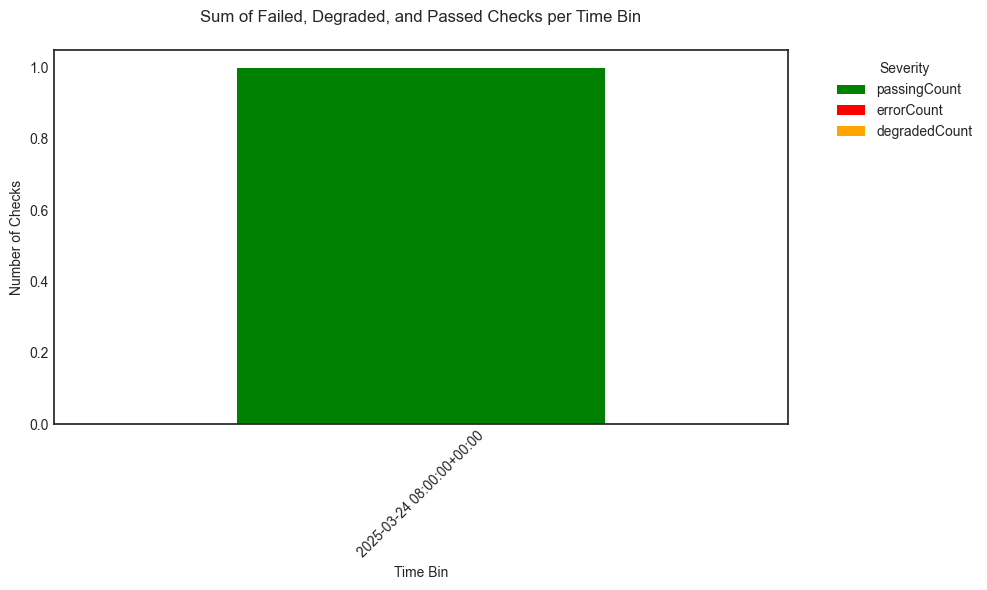

In [81]:
import matplotlib.pyplot as plt

# Prepare data for the stacked bar chart
columns = [time_slices['startedAtBin'], time_slices['passingCount'], time_slices['errorCount'], time_slices['degradedCount']]

import matplotlib.pyplot as plt

# Define colors for each severity level
colors = {
    'passingCount': 'green',
    'errorCount': 'red',
    'degradedCount': 'orange'
}

# Prepare data for the stacked bar chart
stacked_data = time_slices[['startedAtBin', 'passingCount', 'errorCount', 'degradedCount']].set_index('startedAtBin')

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

stacked_data.plot(kind='bar', stacked=True, color=[colors[col] for col in stacked_data.columns], ax=ax)

# Customize plot
ax.set_title('Sum of Failed, Degraded, and Passed Checks per Time Bin', pad=20)
ax.set_xlabel('Time Bin')
ax.set_ylabel('Number of Checks')
ax.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


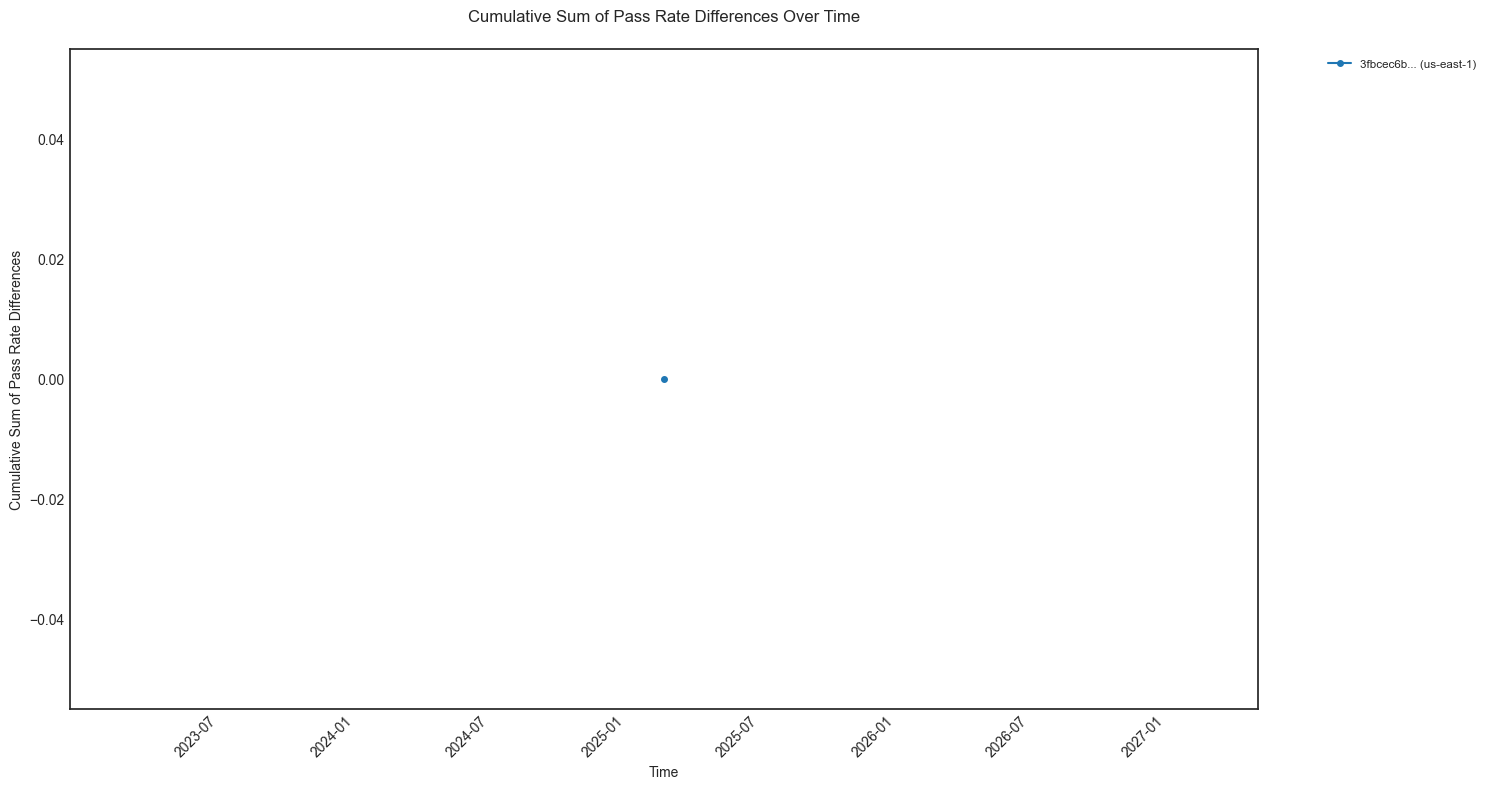

In [82]:
# Create visualization of cumSumPassRate
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(15, 8))

# Plot lines for each check/location combination
for (check_id, location), group in time_slices.groupby(['checkId', 'runLocation']):
    label = f"{check_id[:8]}... ({location})"
    ax.plot(group['startedAtBin'], group['cumSumPassRate'], 
            label=label, marker='o', markersize=4)
    
    # # Add markers for change points
    # change_points = group[group['isCheckPoint']]
    # if not change_points.empty:
    #     ax.scatter(change_points['startedAtBin'], change_points['cumSumPassRate'],
    #               s=100, marker='*', c='red', zorder=5)

# Add markers for change points from change_points_df
for _, row in change_points_df.iterrows():
    ax.scatter(row['startedAtBin'], row['cumSumPassRate'],
               s=100, marker='*', c='red', zorder=5)
# Plot threshold lines for each check/location combination
for (check_id, location), group in time_slices.groupby(['checkId', 'runLocation']):
    # Get the standard deviation threshold for this check/location
    std_dev = group['passRateStdDev'].iloc[0]
    
    # Plot upper threshold line (2 * std_dev)
    ax.axhline(y=2 * std_dev, linestyle='--', color='gray', alpha=0.5)
    
    # Plot lower threshold line (-2 * std_dev)
    ax.axhline(y=-2 * std_dev, linestyle='--', color='gray', alpha=0.5)
    
    # Add text labels for the threshold lines
    ax.text(group['startedAtBin'].iloc[0], 2 * std_dev, f'+2σ', 
            verticalalignment='bottom', fontsize=8, color='gray')
    ax.text(group['startedAtBin'].iloc[0], -2 * std_dev, f'-2σ', 
            verticalalignment='top', fontsize=8, color='gray')
    
    # Only need to plot once per check/location
    break


# Customize plot
ax.set_title('Cumulative Sum of Pass Rate Differences Over Time', pad=20)
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Sum of Pass Rate Differences')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend with smaller font outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()